<a href="https://colab.research.google.com/github/ConradBitt/processamento_linguagem_natural/blob/master/Word2Vec_Interpreta%C3%A7%C3%A3o_da_linguagem_com_word_embedding_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução 

O objetivo deste notebook é aprender as chamadas word embedding que são basicamente transformações de textos em vetores, forma que será utilizada para a transformação é conhecida como *one-hot-encoding* que transforma em matrizes esparças de ordem $n$

Além disso, será abordado alguns assuntos sobre o Word2vec que é uma forma de representar uma palavra através de um vetor denso também de tamanho fixo, a vantagem de dessa representação é que muitos modelos conseguem entender o contexto da palavra, por exemplo as palavras *Brasil, China, Peugeot, Ferrari, Bulgaria*, podem ser classificadas em países e carros.

A diferença do one-hot-encoding é que as palavras são vetores independentes e não tem conexão entre elas, já em word2vec as palavras são expressas em vetores que pertencem a um espaço vetorial capaz de clusterizar grupos de palavras de um mesmo contexto.

O Word2vec é extremamente poderozo, pois funciona de duas formas. A primeira é dado um contexto, por exemplo: 

> **Morar no país ____** 

ele consegue estimar soluções para  possível frase. Matematicamente a modelagem é:

$$\vec{v} = (\text{morar, no, país})$$

$$T(\vec{v}) = \text{europeu}.$$

Existe outra forma de utilizar o Word2Vec, que é, através da palavra tentar estimar o contexto, por exemplo:

> **____ __ ____ europeu**

basicamente será encontrar a transformação $T$ inversa, essa técnica é chamada de skipgram ou *proximo grama*.


## Montando Drive

O motivo de usar o colaboratory é porque processamento de linguagem envolve muita memoria RAM e portanto rodar localmente pode se tonar um tanto custoso.Além disso, através do calab é permitido montar uma imagem do drive onde podemos armazenar os dados. Por esses dois motivos optei pelo google colab:

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importações

In [54]:
import pandas as pd 
import seaborn as sns 
import numpy as np

from matplotlib import pyplot as plt

sns.set_context('talk')


## Dados 

Os dados são basicamente artigos de jornais

In [55]:
treino = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/word2vec/dados/treino.csv')
teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/word2vec/dados/teste.csv')

In [56]:
display(treino.info())
display(teste.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        90000 non-null  object
 1   text         90000 non-null  object
 2   date         90000 non-null  object
 3   category     90000 non-null  object
 4   subcategory  17175 non-null  object
 5   link         90000 non-null  object
dtypes: object(6)
memory usage: 4.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20513 entries, 0 to 20512
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20513 non-null  object
 1   text         20513 non-null  object
 2   date         20513 non-null  object
 3   category     20513 non-null  object
 4   subcategory  6794 non-null   object
 5   link         20513 non-null  object
dtypes: object(6)
memory usage: 961.7+ KB


None

Temos: 
* 90000 registros nos dados de treino.
* 20513 registros nos dados de teste.

todos os dados são do tipo object, porvavelmente strings dividos em 6 variaveis, `titulo`, `text`, `date`, `category`, `subcategory`, `link`.

Vamos dar uma olhada na distribuição das categorias e subcategorias: 

In [57]:
print('Categorias:')
treino.category.value_counts()


Categorias:


mercado      15000
ilustrada    15000
mundo        15000
colunas      15000
esporte      15000
cotidiano    15000
Name: category, dtype: int64

Note que as categorias principais estar distribuidas de forma homogênea, isto é, temos 15000 amostras em cada uma. 

In [58]:
print('Sub Categoria:')
treino.subcategory.value_counts()

Sub Categoria:


olimpiada-no-rio     2144
monicabergamo        1874
mercadoaberto         736
josesimao             472
helioschwartsman      455
                     ... 
thales-de-menezes       1
samyadguirni            1
fabio-victor            1
naiefhaddad             1
ricardo-mioto           1
Name: subcategory, Length: 227, dtype: int64

diferente das categorias, as subcategorias não estão igualmente distribuidas, tem assuntos mais citados do que outros, vamos olhar as 20 primeiras em um grafico de barras:

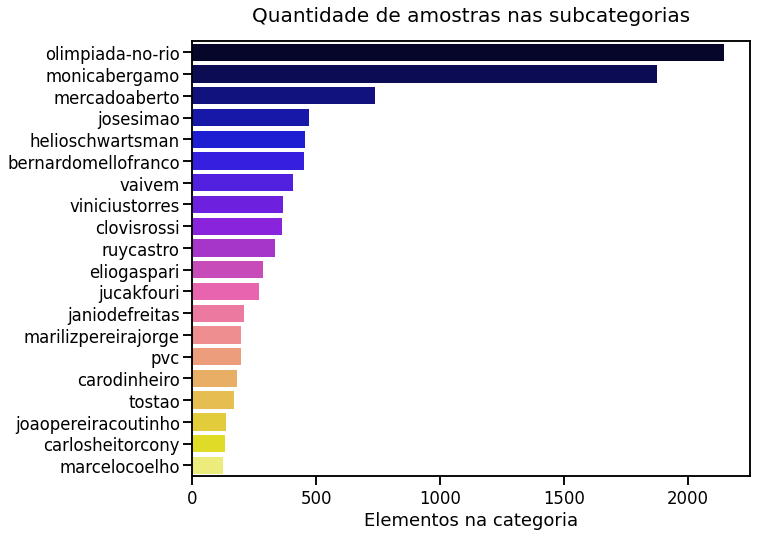

In [59]:
distribuicao_subcategorias = treino.subcategory.value_counts().to_frame()

plt.figure(figsize=(10,8))
plt.title('Quantidade de amostras nas subcategorias', fontsize=20, pad=20)
ax = sns.barplot(data=distribuicao_subcategorias[:20], 
            x='subcategory', 
            y=distribuicao_subcategorias.index[:20], palette='gnuplot2')
ax.set_xlabel('Elementos na categoria')
ax;

## Pre processamento 

Vemos que algumas variááveis são do tipo textual, por exemplo o conteúdo de um artigo e o seu título

In [60]:
display(treino.iloc[645]['title'])
print('\n')
display(treino.iloc[645]['text'])

'Após maior derrota, Anderson Silva volta com outro modelo de preparação'

'Um Anderson Silva diferente do que deixou o octógono com a perna esquerda fraturada há 13 meses retorna ao UFC, nesta madrugada de sábado para domingo, para enfrentar o norte-americano Nick Diaz, em Las Vegas, nos Estados Unidos.  Enquanto veste os apetrechos para a aula de mergulho, Anderson, 39, olha para o lado e sorri para a mulher e dois de seus filhos que se preparam para acompanhá-lo na aula, em Los Angeles.  Esse é um dos relatos do Spider aos colegas de treino sobre como esse pausa permitiu a ele, enfim, passar um tempo com a família para "ver os filhos crescerem".  No começo da carreira, antes de o UFC surgir, Anderson passava a maior parte do tempo fora de casa, dando aulas de artes marciais para manter, com muita dificuldade, sua família. Com a fama, os ganhos aumentaram, mas o convívio com a família, não.  "Até então, o Anderson passava a maior parte do tempo viajando, treinando, lutando. Ou tinha de atender a outros compromissos", conta Rodrigo "Minotauro" Nogueira, amig

dito isso precisamos realizar um pré processamento, isto é, vetorizar estas informações e realizar alguns tratamentos na string em si, como retirar acentos, caracteres especiais, letras maiusculas e minusculas.

## Vetor de palavras

Para perguntas se uma pessoa tem um carro inglês usamos a frase:

> Do you have a car?

E ai aprendemos como fazer uma pergunta em inglês, saimos então perguntando para todas as pessoas possíveis: *Do you have a car? Do you have a car? Do you have a car?*. Ai geralmente as pessoas pegam a "ideia" de como é a estrutura de uma pergunta, e agora como fazemos pra perguntar se uma mulher tem um carro? Bom usamos a frase:

> Does she have a car?

Então perguntamos para todas as pessoas que conhecemos: *Does she have a car? Does she have a car? Does she have a car?*. Note que só mudamos o sujeito da frase, no caso foram duas palavras, e criou-se uma nova frase a partir da *Do you have a car?*.

Agora queremos saber se ela tem uma bicicleta, como faríamos?

> Does she have a bike?

Note que o que mudamos apenas algumas palavras da frase. Ou seja, aprendemos uma estrutura da frase e a partir dela conseguimos várias outras, isso significa que fomos capazes de generalizar a frase.

### Vetorizando uma frase

Vamos supor que temos as seguintes frases:

> TENHA UM BOM DIA

> TENHA UM ÓTIMO DIA

> TENHA UM PÉSSIMO DIA

É comum chamar de *corpus textual* o conjunto de todas as frases que se tem, por exemplo, a variável ``text`` dos dados de treino é o nosso corpus textual.

Para vetorizar uma frase, a primeira coisa que deve ser feita é pegar as palavras do corpus textual sem repetição. Aplicando isso ao nosso corpus teríamos: 

> TENHA UM **BOM ÓTIMO PÉSSIMO** DIA

Quando retiramos palavras repetidas de um corpus criamos um *vocabulário* e a partir do vocabulário contruimos um vetor que auxilie a não confundir as palavras *BOM* com *TENHA* ou com *ÓTIMO*. 

$$\vec{v} = (\text{TENHA, UM, BOM, ÓTIMO, PÉSSIMO, DIA})$$

Aqui podemos tirar uma conclusão: o vetor da palavra terá a mesma dimensão do corpus textual.

Outra forma de expressar uma frase é atraves de uma matriz:

$$
A = \begin{pmatrix} 
  1 & 0 & 0 & 0 & 0 & 0 \\ 
  0 & 1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 1 & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 \\
  \end{pmatrix}
$$

Desse forma **as palavras estão expressas nas colunas**, e portanto são linearmente independentes. Então temos um vetor de ordem $n$ que representa uma palavra de um vocabulário, esta é a técnica chamada de *one-hot-encoding*.


#### Exemplo: 
Vamos vetorizar uma frase, por exemplo: 

> O corretor de imóveis vendeus 5 casas

> A corretora de imóveis vendeus 6 apartamentos

In [90]:
texto = [
    'TENHA UM BOM DIA',
    'TENHA UM ÓTIMO DIA',
    'TENHA UM PÉSSIMO DIA'
]

def vetoriza_frase(frases):
  vocabulario = []
  for frase in frases:
    vetor_frase = frase.split(' ')
    for palavra in vetor_frase:
      if palavra not in vocabulario:
        vocabulario.append(palavra)
  return vocabulario

vocabulario = vetoriza_frase(texto)
print(vocabulario)

['TENHA', 'UM', 'BOM', 'DIA', 'ÓTIMO', 'PÉSSIMO']


Note que o vocabulário poderia esta necessariamente ordenado na ordem que desejamos. Sim, por definição um vetor é uma *$n$-upla ordenada*, entretanto quando juntamos os vetores de palavras em uma matriz, é permitido trocar linhas e colunas de lugar, assim como é permitido trocar palavras em uma frase. Então, um vocabulário é um vetor que pertence à um espaço vetorial cujo os vetores de base são as palavras vetorizadas.

A implementação do código acima funciona para pequenos textos, mas para grandes volumes de dados ela pode ter um desempenho não tão eficiente. Portanto, vamos utilizar um módulo chamado Sci Kit Learning que tem uma função capaz de vetorizar corpus textuais.

O SKLearn tem todo um ferramental de machine learning, em especial o módulo: [sklearn.feature_extraction.text](https://sklearn.org/modules/classes.html#module-sklearn.feature_extraction.text) é voltado exclusivamente para texto. A rotina que vou utilizar deste módulo é a ``CountVectorizer()``

A descrição deste objeto é: 

```python
class sklearn.feature_extraction.text.CountVectorizer(input=’content’, encoding=’utf-8’,
 decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, 
 tokenizer=None, stop_words=None, token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1),
  analyzer=’word’, max_df=1.0, min_df=1, max_features=None,
   vocabulary=None, binary=False, dtype=<class ‘numpy.int64’>)
```

    Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of
    feature selectionthen the number of features will be equal to the vocabulary size found by analyzing the data.

[Read more in the User Guide](https://sklearn.org/modules/feature_extraction.html#text-feature-extraction).

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

Vamos textar a função com a frase que já propomos: 

In [92]:
texto = [
    'TENHA UM BOM DIA',
    'TENHA UM ÓTIMO DIA',
    'TENHA UM PÉSSIMO DIA'
]

# criando um vetorizador 
vetorizador = CountVectorizer()

# ajustando o vetorizador ao texto
vetorizador.fit(texto)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [93]:
print(vetorizador.vocabulary_)


{'tenha': 3, 'um': 4, 'bom': 0, 'dia': 1, 'ótimo': 5, 'péssimo': 2}


note que ele criou um dicionario com todas as palavras que não se repetem. Agora surge a vantagem do SK Learning, como seria o vetor da palavra ``BOM``?

Para isso pegamos o objeto vetorizador:

In [96]:
vetor_bom = vetorizador.transform(['BOM'])
vetor_bom

<1x6 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

O resultado é uma matriz esparsa de ordem 1x6. Podemos transformar esta matriz em um array para visualiza-la

In [98]:
print(vetor_bom.toarray())

[[1 0 0 0 0 0]]


A palavra ``BOM`` é expressa pelo vetor $(1,0,0, 0, 0, 0)$. Podemos saber qual o elemento não nulo do vetor apenas olhando os valores do vocabulario:

In [99]:
print(vetorizador.vocabulary_)

{'tenha': 3, 'um': 4, 'bom': 0, 'dia': 1, 'ótimo': 5, 'péssimo': 2}


Se quisermos formar as frases:

> BOM DIA: $$(1,0,0,0,0,0) + (0,1,0,0,0,0) = (1,1,0,0,0,0)$$

> PÉSSIMO DIA: $$(0,0,1,0,0,0) + (0,1,0,0,0,0) = (0,1,1,0,0,0)$$

Note que as frases são diferentes porquê os vetores são diferente... 

A dimenssionalidade da frase implica diretamente na dimenssionalidade do vocabulario, pois a dimenssionalidade do vocabulário é no minimo igual ou menor que a da frases e isso pode ser um problema computacionalmente.

> Um simples tweets de 240 caracteres pode gerar um vetor de ordem $(1,240)$.

Ai surge uma outra forma de tentar expressar frases através de vetores, visando evitar esse problema de matrizes e vetores esparsos. 